In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.insert(0, "../scripts")

from SZFW_cox import *
from DZFW_cox import *
from IZFW_cox import *

## Load data

In [3]:
clinical = pd.read_table('../Data/SurvivalTimes.txt', index_col=0, sep=';')
clinical = clinical.set_index(clinical["IDs"], drop=True).iloc[:,:-1]
clinical["death_event"].value_counts()

0    375
1    162
Name: death_event, dtype: int64

In [4]:
data = pd.read_table("../Data/mydata.txt", sep = ";")
data = data.T

In [5]:
df = data.merge(clinical, left_index= True, right_index = True)
df = df.sort_values(by = "new_death")
df.head()

,?|10431,?|553137,?|57714,?|653553,?|8225,A2M|2,A4GALT|53947,AAAS|8086,AACS|65985,AAGAB|79719,...,ZSWIM7|125150,ZW10|9183,ZXDB|158586,ZXDC|79364,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009,new_death,death_event
TCGA-A3-A8OX,864.8329,123.6901,762.7553,259.3501,527.3452,32553.2802,972.8954,525.3502,734.8253,741.1428,...,470.8900,328.5101,289.2751,967.5754,990.5179,4045.8617,1415.1206,592.1828,0,0
TCGA-A3-A8OU,642.0154,431.5319,624.5429,399.0248,788.7038,31333.4945,1786.6721,702.1536,526.2089,503.0475,...,419.2483,250.7111,383.1776,1112.9622,899.2280,4225.9244,1418.1227,449.8171,0,0
TCGA-BP-4337,934.0463,772.7273,466.1319,596.2567,699.6435,32191.5642,2510.2496,938.0570,881.4617,651.9608,...,267.3975,228.6096,189.8396,1154.1889,616.7558,5067.7362,1319.0731,471.0339,2,1
TCGA-A3-A8CQ,477.9031,283.6534,722.9503,337.7019,779.4372,31045.7665,1935.5887,615.6660,712.7908,408.4121,...,250.2895,289.7491,376.3080,1091.9435,967.9976,3791.5270,1752.7177,611.6022,3,0
TCGA-A3-A6NN,310.8729,556.6616,915.3905,234.3032,463.6294,40603.1432,2385.1455,638.2083,343.4150,494.6401,...,282.2358,351.8377,465.1608,907.7335,1130.1685,2765.3139,2091.5008,774.1194,3,0


In [6]:
X, y, time = df.iloc[:,:-2], df.iloc[:,-1].values, df.iloc[:,-2].values
X = np.array(X.apply(lambda x: (x - np.mean(x))/np.std(x), axis = 0))
print(f"X shape: {X.shape}\ny shape: {y.shape}\ntime shape: {time.shape}")

X shape: (533, 9375)
y shape: (533,)
time shape: (533,)


In [7]:
n, d = X.shape

In [8]:
# initialize parameters for the algorithms
# stating point 
np.random.seed(7)
w0 = np.random.rand(d)
w0 = w0/np.sum(w0) * np.random.rand(1) *10

# Lipschitz constant 
L = 50

In [9]:
np.linalg.norm(w0, 1)

8.899985191618605

In [10]:
@njit
def F(w):
    output = 0
    for i in range(X.shape[0]):
        if y[i] == 1:
            sum_jR = np.sum(np.exp((X @ w)[i:]))
            output += y[i]*(-X[i,:] @ w + np.log(sum_jR))
    return 1/X.shape[0] * output

## Deterministic Gradient Free Frank Wolfe

In [12]:
%%time
fpred, f, w, mean, t, loss, f_values = detZFW(F, L, d, w0, T=100)

KeyboardInterrupt: 

In [13]:
print(F(w0), F(w))
print(f'OUTPUT:\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

NameError: name 'w' is not defined

## Stochastic Gradient Free Frank Wolfe

In [ ]:
%%time
fpred, f, w, mean, t, loss = stochasticZFW(F, d, w0, method = "IRDSA", r=10, T=20, eps=1e-5)

In [ ]:
print(F(w0), F(w))
print(f'OUTPUT:\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

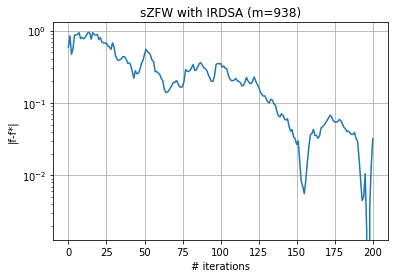

In [17]:
f_stoch200 = np.load('../Data/results/function_SZFW_IRDSA_cox_200.npy')
plt.plot(f_stoch200 - np.min(f_stoch200))
plt.yscale("log")
plt.title("sZFW with IRDSA (m=938)")
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.grid()

## Zeroth order stochastic accelerated gradient method with Inexact updates

In [11]:
%%time

# setting parameters
B=1   
D=10000

fpred, f, w, mean, t, loss = IZFW(F, d, w0, L, B = 1, r = 10, T = 1, eps = 1e-5)

KeyboardInterrupt: 

In [16]:
((322040 * 661*10**(-3) / 60)/60)

59.13012222222222

2.1905202447317853 1.6765191478450465
OUTPUT:

F(w_pred) = 1.678198563891779

F(w) = 1.6765191478450465

w = [ 2.82792244e-08  5.99616182e-04 -3.88102951e-05 ...  3.98960124e-04
  1.24004937e-03  1.90532377e-07]

average w = [ 1.42810083e-06  1.06801625e-03 -9.58246693e-05 ...  2.34332459e-04
  5.99198484e-04  9.62188506e-06]

T = 100


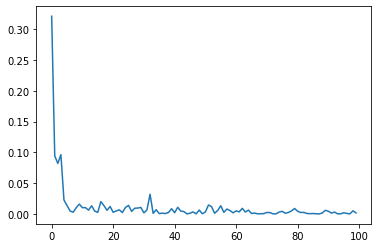

In [17]:
print(F(w0), F(w))
print(f'OUTPUT:\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

/home/laura/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  This is separate from the ipykernel package so we can avoid doing imports until


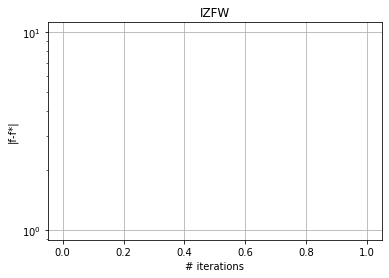

In [18]:
f_i = np.load('../Data/results/function_IZFW_cox.npy')
plt.plot(f_i - np.min(f_i))
plt.yscale("log")
plt.title("IZFW")
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.grid()